In [1]:
pip install datasets

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openai

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Using cached openai-2.6.1-py3-none-any.whl.metadata (29 kB)
  Using cached jiter-0.11.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.2 kB)
Using cached openai-2.6.1-py3-none-any.whl (1.0 MB)
Using cached jiter-0.11.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (358 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openai]2m1/2 [openai]
Note: you may need to restart the kernel to use updated packages.


In [1]:
from datasets import load_dataset

dataset = load_dataset("Schnowflake/playing_cards_excercise", split="test")

In [2]:
print(dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x720 at 0x7F28D8BB3EC0>, 'qa': [{'question': 'what cards are in the image?', 'answer': '8 of heart, 10 of diamond, 10 of heart'}]}


In [3]:
print(len(dataset))

200


# Load Model

In [4]:
from unsloth import get_chat_template
from unsloth import FastVisionModel

"""
model, processor = FastVisionModel.from_pretrained(
    model_name="lora_model_cards",  # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit=True,  # Set to False for 16bit LoRA
)

"""
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)


FastVisionModel.for_inference(model)  # Enable for inference!



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


[torchao|WARNING]Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.11: Fast Qwen2_5_Vl patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100 80GB PCIe MIG 1g.10gb. Num GPUs = 1. Max memory: 9.5 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLU()

In [35]:
import re
from openai import OpenAI

def VLM_Call(image):

    instruction = "What cards are in the image?"

    messages = [
        {
            "role": "user",
            "content": [{"type": "image"}, {"type": "text", "text": instruction}],
        }
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)


    inputs = tokenizer(
        image,
        str(input_text),  
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    result = model.generate(**inputs, max_new_tokens = 128,
                            use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)
    
    text_back = tokenizer.decode(result[0], skip_special_tokens=True)
    after = text_back.split("assistant", 2)[2] if "assistant" in text_back else text_back #might have to change when mentioning it in the prompt
   
    return after

2 of diamond, 4 of club, 6 of club


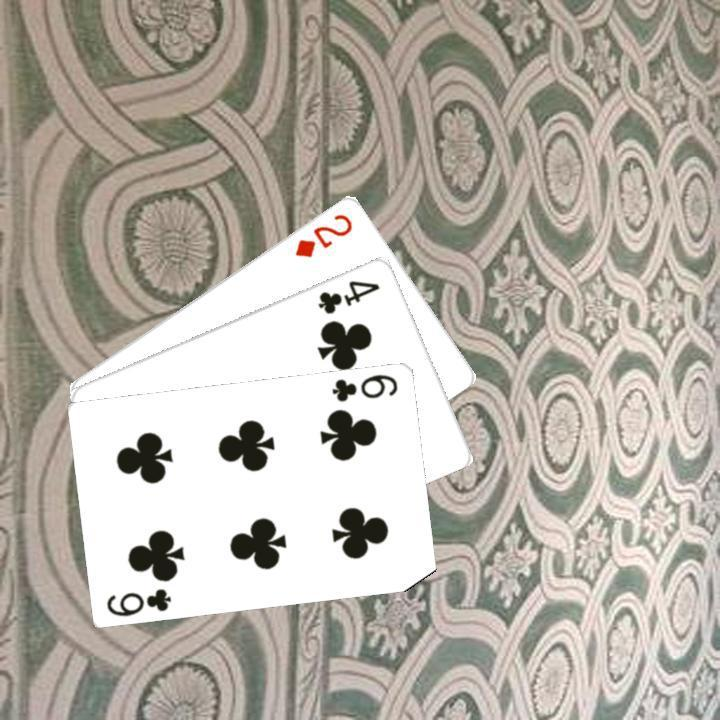


The image shows four playing cards. From top to bottom, they are:

1. A Diamond Two (2♦)
2. A Club Four (4♣)
3. A Club Six (6♣)
4. A Club Nine (9♣)


In [36]:
image = dataset[1]["image"]

print(dataset[1]["qa"][0]["answer"])
display(image)
print(VLM_Call(image))

In [37]:
def correct_or_not(groundtruth, vlm_answer):
    # Normalize both strings: lowercase and remove punctuation
    gt = groundtruth.lower().strip()
    answer = vlm_answer.lower().strip()

    # Extract all cards from the groundtruth (pattern: e.g. "a of club", "10 of hearts", "q of spade")
    cards = re.findall(r'\b(?:[2-9]|10|[jqka]) of [a-z]+\b', gt)

    # Check that every card from groundtruth appears in the answer
    all_present = all(card in answer for card in cards)

    if all_present:
        return "correct!"
    else:
        return "wrong!"
    
    return None

In [38]:
total_correct = 0

data_to_safe = []

for row in dataset:
    vlm_answer = VLM_Call(row["image"])
    judge_answer = correct_or_not(vlm_answer, row["qa"][0]["answer"])
    if "correct" in judge_answer:
        total_correct += 1
        print("correct!")
    else:
        #print(row["qa"][0]["answer"])
        #print(vlm_answer)
        print("Not correct!")

    data = {}
    data["Groundtruth"] = row["qa"][0]["answer"]
    data["VLM"] = vlm_answer
    data["Judge"] = judge_answer

    data_to_safe.append(data)

print(total_correct)

correct!
correct!
correct!
correct!
correct!
correct!
Not correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!
correct!


KeyboardInterrupt: 

In [39]:
import pandas as pd

df = pd.DataFrame.from_dict(data_to_safe)
df.to_csv("Results_non_tuned_easyALG.csv", sep=',', encoding='utf-8', index=False, header=True)